
## Step 0: Setting up

The following cells make sure that environment is setup correctly, download the data if you don't have it already, and also check that GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Landmark_classification_tagging')
print(f"Current working directory: {os.getcwd()}")

Current working directory: /content/drive/MyDrive/Landmark_classification_tagging


In [ ]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

In [ ]:
!pip install livelossplot

Important! After you have ran pip install, please restart the kernel using the **Kernel** menu

In [ ]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at
# least 2 Gb of space on your hard drive)
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


---
## Step 1: Data



In [ ]:
!pytest -vv src/data.py -k data_loaders

============================= test session starts ==============================
platform linux -- Python 3.11.13, pytest-8.3.5, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/Landmark_classification_tagging
plugins: anyio-4.9.0, typeguard-4.4.4, langsmith-0.4.1
collected 4 items / 1 deselected / 3 selected                                  

src/data.py::test_data_loaders_keys PASSED                               [ 33%]
src/data.py::test_data_loaders_output_type PASSED                        [ 66%]
src/data.py::test_data_loaders_output_shape PASSED                       [100%]

======================= 3 passed, 1 deselected in 10.91s =======================


 **Question:** Describe your chosen procedure for preprocessing the data.
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

 **Answer**: My code first resizes the image to 256 and then crops to 224. I picked 224 as the input size because it is the recommended input size for using pytorch's pre-trained models. I did decide to augment the dataset via RandomAffine,ColorJitter, RandomHorizontalFlip, GaussianBlur, to handel different angels, distances, out-focus images, mirrored images, differnet color or camera settings. I added this augmentation with the goal of improving my model's robustness, thus improving test accuracy.

### Visualize a Batch of Training Data


In [ ]:
!pytest -vv src/data.py -k visualize_one_batch

============================= test session starts ==============================
platform linux -- Python 3.11.13, pytest-8.3.5, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/Landmark_classification_tagging
plugins: typeguard-4.4.3, anyio-4.9.0, langsmith-0.3.45
collected 4 items / 3 deselected / 1 selected                                  

src/data.py::test_visualize_one_batch PASSED                             [100%]

======================= 1 passed, 3 deselected in 4.87s ========================


Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])
Reusing cached mean and std


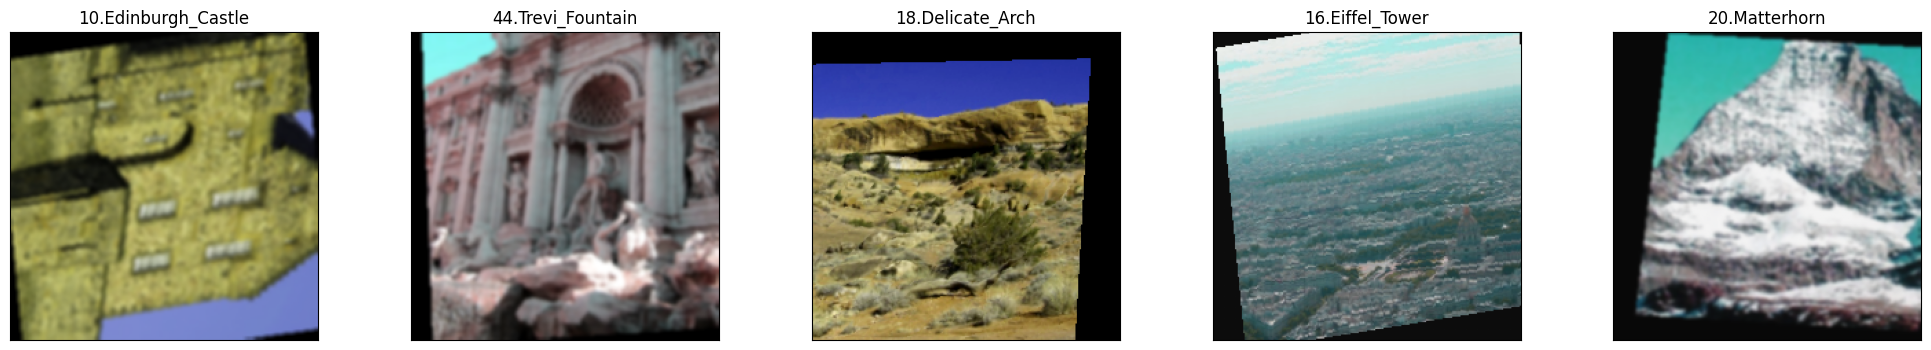

In [ ]:
%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders
import multiprocessing

# use get_data_loaders to get the data_loaders dictionary. Use a batch_size
# of 5, a validation size of 0.01 and num_workers=multiprocessing.cpu_count() (all CPUs)
data_loaders = get_data_loaders(batch_size=5, valid_size=0.01, num_workers=multiprocessing.cpu_count() )

visualize_one_batch(data_loaders)

In [ ]:
from src.data import  get_data_loaders
import multiprocessing


data_loaders = get_data_loaders(batch_size=5, valid_size=0.01, num_workers=multiprocessing.cpu_count() )



train_loader = data_loaders["train"]
train_length = len(train_loader.dataset)  # Total samples
train_batches = len(train_loader)         # Number of batches

print(f"Training samples: {train_length}")
print(f"Training batches: {train_batches}")
print(f"Class Names: {train_loader.dataset.classes}")

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])
Training samples: 4996
Training batches: 990
Class Names: ['00.Haleakala_National_Park', '01.Mount_Rainier_National_Park', '02.Ljubljana_Castle', '03.Dead_Sea', '04.Wroclaws_Dwarves', '05.London_Olympic_Stadium', '06.Niagara_Falls', '07.Stonehenge', '08.Grand_Canyon', '09.Golden_Gate_Bridge', '10.Edinburgh_Castle', '11.Mount_Rushmore_National_Memorial', '12.Kantanagar_Temple', '13.Yellowstone_National_Park', '14.Terminal_Tower', '15.Central_Park', '16.Eiffel_Tower', '17.Changdeokgung', '18.Delicate_Arch', '19.Vienna_City_Hall', '20.Matterhorn', '21.Taj_Mahal', '22.Moscow_Raceway', '23.Externsteine', '24.Soreq_Cave', '25.Banff_National_Park', '26.Pont_du_Gard', '27.Seattle_Japanese_Garden', '28.Sydney_Harbour_Bridge', '29.Petronas_Towers', '30.Brooklyn_Bridge', '31.Washington_Monument', '32.Hanging_Temple', '33.Sydney_Opera_House', '34.Great_Barrier_Reef', '35.Monumento_a_la

In [ ]:
import numpy as np
from collections import Counter

# Count images per class
if hasattr(train_loader.dataset, 'targets'):
    # For datasets like CIFAR10, MNIST, etc.
    targets = train_loader.dataset.targets
    class_counts = np.bincount(targets)
elif hasattr(train_loader.dataset, 'labels'):
    # Some datasets use 'labels' instead of 'targets'
    labels = train_loader.dataset.labels
    class_counts = np.bincount(labels)
else:
    # Manual counting by iterating through dataset
    labels = [train_loader.dataset[i][1] for i in range(len(train_loader.dataset))]
    class_counts = np.bincount(labels)

# Print results
print("\nImages per class:")
for i, count in enumerate(class_counts):
    class_name = train_loader.dataset.classes[i]
    print(f"{class_name}: {count} images")


Images per class:
00.Haleakala_National_Park: 100 images
01.Mount_Rainier_National_Park: 100 images
02.Ljubljana_Castle: 100 images
03.Dead_Sea: 100 images
04.Wroclaws_Dwarves: 100 images
05.London_Olympic_Stadium: 100 images
06.Niagara_Falls: 100 images
07.Stonehenge: 100 images
08.Grand_Canyon: 100 images
09.Golden_Gate_Bridge: 100 images
10.Edinburgh_Castle: 100 images
11.Mount_Rushmore_National_Memorial: 100 images
12.Kantanagar_Temple: 100 images
13.Yellowstone_National_Park: 100 images
14.Terminal_Tower: 100 images
15.Central_Park: 100 images
16.Eiffel_Tower: 100 images
17.Changdeokgung: 100 images
18.Delicate_Arch: 100 images
19.Vienna_City_Hall: 100 images
20.Matterhorn: 100 images
21.Taj_Mahal: 100 images
22.Moscow_Raceway: 100 images
23.Externsteine: 100 images
24.Soreq_Cave: 100 images
25.Banff_National_Park: 100 images
26.Pont_du_Gard: 100 images
27.Seattle_Japanese_Garden: 100 images
28.Sydney_Harbour_Bridge: 100 images
29.Petronas_Towers: 100 images
30.Brooklyn_Bridge: 1

---
## Step 2: Define model, loss and optimizer


In [ ]:
!pytest -vv src/CNN_model.py

============================= test session starts ==============================
platform linux -- Python 3.11.13, pytest-8.3.5, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/Landmark_classification_tagging
plugins: typeguard-4.4.3, anyio-4.9.0, langsmith-0.3.45
collected 1 item                                                               

src/CNN_model.py::test_model_construction PASSED                         [100%]

============================== 1 passed in 6.64s ===============================


**Question**: Outline the steps you took to get to your final CNN architecture and your reasoning at each step?

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/> __Answer:__I developed the CNN architecture by stacking convolutional layers with increasing channels, batch normalization, and ReLU activations, followed by max pooling. then used global average pooling in the final layer to adapt to different input sizes and added dropout for regularization before the fully connected layer.

In [ ]:
!pytest -vv src/optimization.py -k get_loss

============================= test session starts ==============================
platform linux -- Python 3.11.13, pytest-8.3.5, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/Landmark_classification_tagging
plugins: typeguard-4.4.3, anyio-4.9.0, langsmith-0.3.45
collected 7 items / 6 deselected / 1 selected                                  

src/optimization.py::test_get_loss PASSED                                [100%]

======================= 1 passed, 6 deselected in 2.06s ========================


In [ ]:
!pytest -vv src/optimization.py -k get_optimizer

============================= test session starts ==============================
platform linux -- Python 3.11.13, pytest-8.3.5, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/Landmark_classification_tagging
plugins: typeguard-4.4.3, anyio-4.9.0, langsmith-0.3.45
collected 7 items / 1 deselected / 6 selected                                  

src/optimization.py::test_get_optimizer_type PASSED                      [ 16%]
src/optimization.py::test_get_optimizer_is_linked_with_model PASSED      [ 33%]
src/optimization.py::test_get_optimizer_returns_adam PASSED              [ 50%]
src/optimization.py::test_get_optimizer_sets_learning_rate PASSED        [ 66%]
src/optimization.py::test_get_optimizer_sets_momentum PASSED             [ 83%]
src/optimization.py::test_get_optimizer_sets_weight_decat PASSED         [100%]

======================= 6 passed, 1 deselected in 2.63s ========================


---
## Step 3: Train and Validate the Model

In [ ]:
!MODEL_TYPE=cnn pytest -vv src/train.py -k train_one_epoch

============================= test session starts ==============================
platform linux -- Python 3.11.13, pytest-8.4.1, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/Landmark_classification_tagging
plugins: typeguard-4.4.4, langsmith-0.4.8, anyio-4.9.0
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_train_one_epoch PASSED                                [100%]

======================= 1 passed, 3 deselected in 49.15s =======================


In [ ]:
!MODEL_TYPE=cnn pytest -vv src/train.py -k valid_one_epoch

============================= test session starts ==============================
platform linux -- Python 3.11.13, pytest-8.4.1, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/Landmark_classification_tagging
plugins: typeguard-4.4.4, langsmith-0.4.8, anyio-4.9.0
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_valid_one_epoch PASSED                                [100%]

======================= 1 passed, 3 deselected in 30.40s =======================


Now complete the `test` function then run the tests:

In [ ]:
!MODEL_TYPE=cnn pytest -vv src/train.py -k one_epoch_test

============================= test session starts ==============================
platform linux -- Python 3.11.13, pytest-8.4.1, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/Landmark_classification_tagging
plugins: typeguard-4.4.4, langsmith-0.4.8, anyio-4.9.0
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_one_epoch_test PASSED                                 [100%]

======================= 1 passed, 3 deselected in 51.94s =======================


In [ ]:
!MODEL_TYPE=cnn pytest -vv src/train.py -k optimize

============================= test session starts ==============================
platform linux -- Python 3.11.13, pytest-8.4.1, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/Landmark_classification_tagging
plugins: typeguard-4.4.4, langsmith-0.4.8, anyio-4.9.0
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_optimize PASSED                                       [100%]

=============================== warnings summary ===============================
src/train.py::test_optimize
  /usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
    warnings.warn(

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
================= 1 passed, 3 deselected, 1 warning in 59.85s ==================


---
## Step 4: Putting everything together


In [ ]:
batch_size = 64    # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2       # fraction of the training data to reserve for validation
num_epochs = 100      # number of epochs for training
num_classes = 50      # number of classes. Do not change this
dropout = 0.4          # dropout for our model
learning_rate = 0.0001  # Learning rate for SGD (or Adam)
opt = 'adam'            # optimizer. 'sgd' or 'adam'
weight_decay = 0.001    # regularization. Increase this to combat overfitting

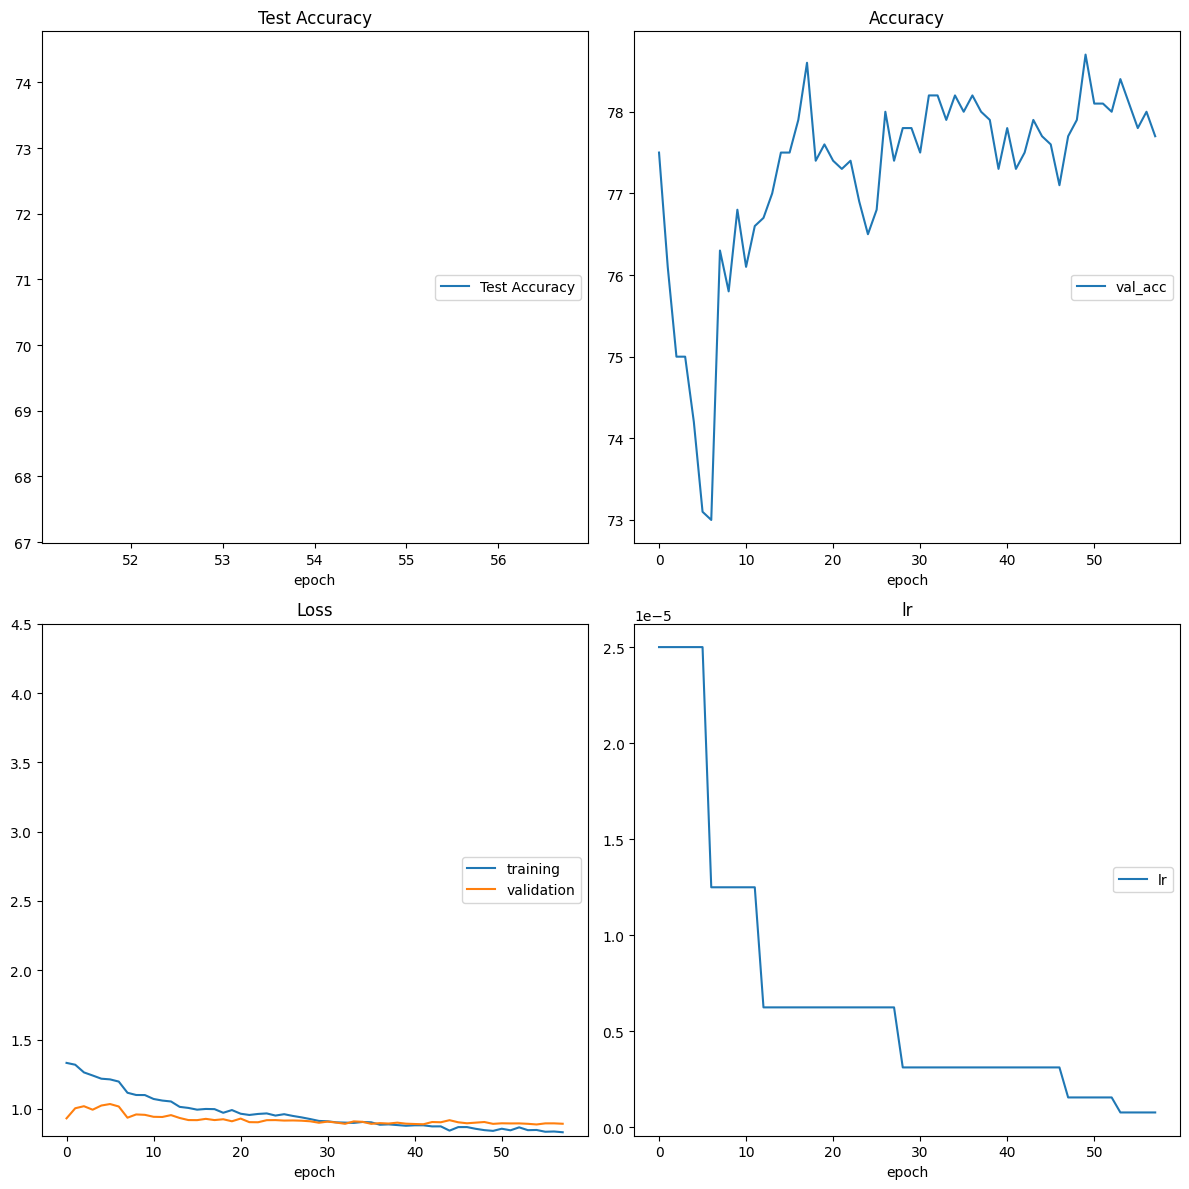

Epoch: 100 	Training Loss: 0.830671 	Validation Loss: 0.891989 	Validation Accuracy: 77.70%


In [ ]:
from src.data import get_data_loaders
from src.train_Cnn import optimize
from src.optimization import get_optimizer, get_loss
from src.CNN_model import MyModel
import multiprocessing
import torch

# get the data loaders using batch_size and valid_size defined in the previous cell
# You can set the number of workers equal to the CPU count obtained using `multiprocessing.cpu_count()`.
gpu_kwargs = {
    "persistent_workers": True,
    "pin_memory": True,
    "pin_memory_device": 'cuda:0',
    "prefetch_factor": 4
}

data_loaders = get_data_loaders(
        batch_size=batch_size,
        valid_size=valid_size,
        num_workers=multiprocessing.cpu_count(),
        **gpu_kwargs)

model = MyModel(num_classes,dropout)

# print(model)
optimizer = get_optimizer(
        model=model,
        optimizer= opt,
        learning_rate=learning_rate,
        weight_decay= weight_decay)

loss = get_loss()

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/best_val_loss_v2.pt",
    interactive_tracking=True,
    resume_training = True
)

---
##  Step 5: testing against the Test Set


In [ ]:
from src.train_Cnn import one_epoch_test
from src.CNN_model import MyModel
import torch
from src.optimization import get_optimizer, get_loss


loss = get_loss()

model = MyModel(num_classes=num_classes, dropout=dropout)

checkpoint_path = 'checkpoints/best_val_loss_v2.pt'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Run test
one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|████████████████████████████████| 250/250 [00:13<00:00, 17.99it/s]

Test Loss: 1.155733


Test Accuracy: 70% (886/1250)


(1.1557328704828393, tensor(70.8800))

---
## Step 6: Export using torchscript


In [ ]:
!pytest -vv src/predictor.py

============================= test session starts ==============================
platform linux -- Python 3.11.13, pytest-8.3.5, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/.shortcut-targets-by-id/1Dvk0aprcS80-G3Zobn9B5PFVxw-123-g/Landmark_classification_tagging
plugins: anyio-4.9.0, langsmith-0.4.1, typeguard-4.4.4
collected 1 item                                                               

src/predictor.py::test_model_construction PASSED                         [100%]

============================== 1 passed in 7.25s ===============================


In [ ]:
# NOTE: you might need to restart the notebook before running this step
# If you get an error about RuntimeError: Can't redefine method: forward on class
# restart your notebook then execute only this cell
from src.predictor import Predictor
from src.helpers import compute_mean_and_std
from src.CNN_model import MyModel
from src.data import get_data_loaders
import torch

data_loaders = get_data_loaders(batch_size=1)

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model = MyModel(num_classes=50, dropout=0.5).cpu()

# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
checkpoint_path = 'checkpoints/best_val_loss_v2.pt'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
# model.load_state_dict(torch.load("checkpoints/best_val_loss_v3.pt", map_location = 'cpu'))

# wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)

scripted_predictor.save("checkpoints/original_exported.pt")

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])
Reusing cached mean and std


## Step 7: Load & Evaluate Exported Model


*   test exported model
*   Calculate F1 Score, classification report
*   visualize_comprehensive_metrics
*   plot confusion matrix



Make sure the exported model has the same performance as the original one, by reloading it and testing it. The Predictor class *takes* different inputs than the non-wrapped model, so we have to use a specific test loop:

In [ ]:
from src.data import get_data_loaders
from src.optimization import  get_loss


data_loaders = get_data_loaders(batch_size=batch_size)
loss = get_loss()
class_names = data_loaders["train"].dataset.classes

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])


In [ ]:
import torch

# Load using torch.jit.load
model_reloaded =  torch.jit.load("checkpoints/original_exported.pt") # YOUR CODE HERE

In [ ]:
import warnings

In [ ]:
from src.predictor import predictor_test

warnings.filterwarnings("ignore") # Disable warnings
pred, truth = predictor_test(data_loaders['test'], model_reloaded)
warnings.filterwarnings("default") # Re-enable warnings

100%|███████████████████████████████████████| 1250/1250 [13:29<00:00,  1.54it/s]

Accuracy: 0.7088



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, classification_report

print(f'F1 Score: {f1_score(truth, pred, average="micro")}, \n Accuracy: {accuracy_score(truth, pred)}, \nReport: {classification_report(truth, pred, target_names=class_names)}')

F1 Score: 0.7088, 
 Accuracy: 0.7088, 
Report:                                      precision    recall  f1-score   support

         00.Haleakala_National_Park       0.64      0.36      0.46        25
     01.Mount_Rainier_National_Park       0.50      0.40      0.44        25
                02.Ljubljana_Castle       0.67      0.80      0.73        25
                        03.Dead_Sea       0.39      0.28      0.33        25
                04.Wroclaws_Dwarves       0.59      0.68      0.63        25
          05.London_Olympic_Stadium       0.86      0.72      0.78        25
                   06.Niagara_Falls       0.81      0.68      0.74        25
                      07.Stonehenge       0.85      0.92      0.88        25
                    08.Grand_Canyon       0.50      0.60      0.55        25
              09.Golden_Gate_Bridge       0.88      0.84      0.86        25
                10.Edinburgh_Castle       0.61      0.56      0.58        25
11.Mount_Rushmore_National_M

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


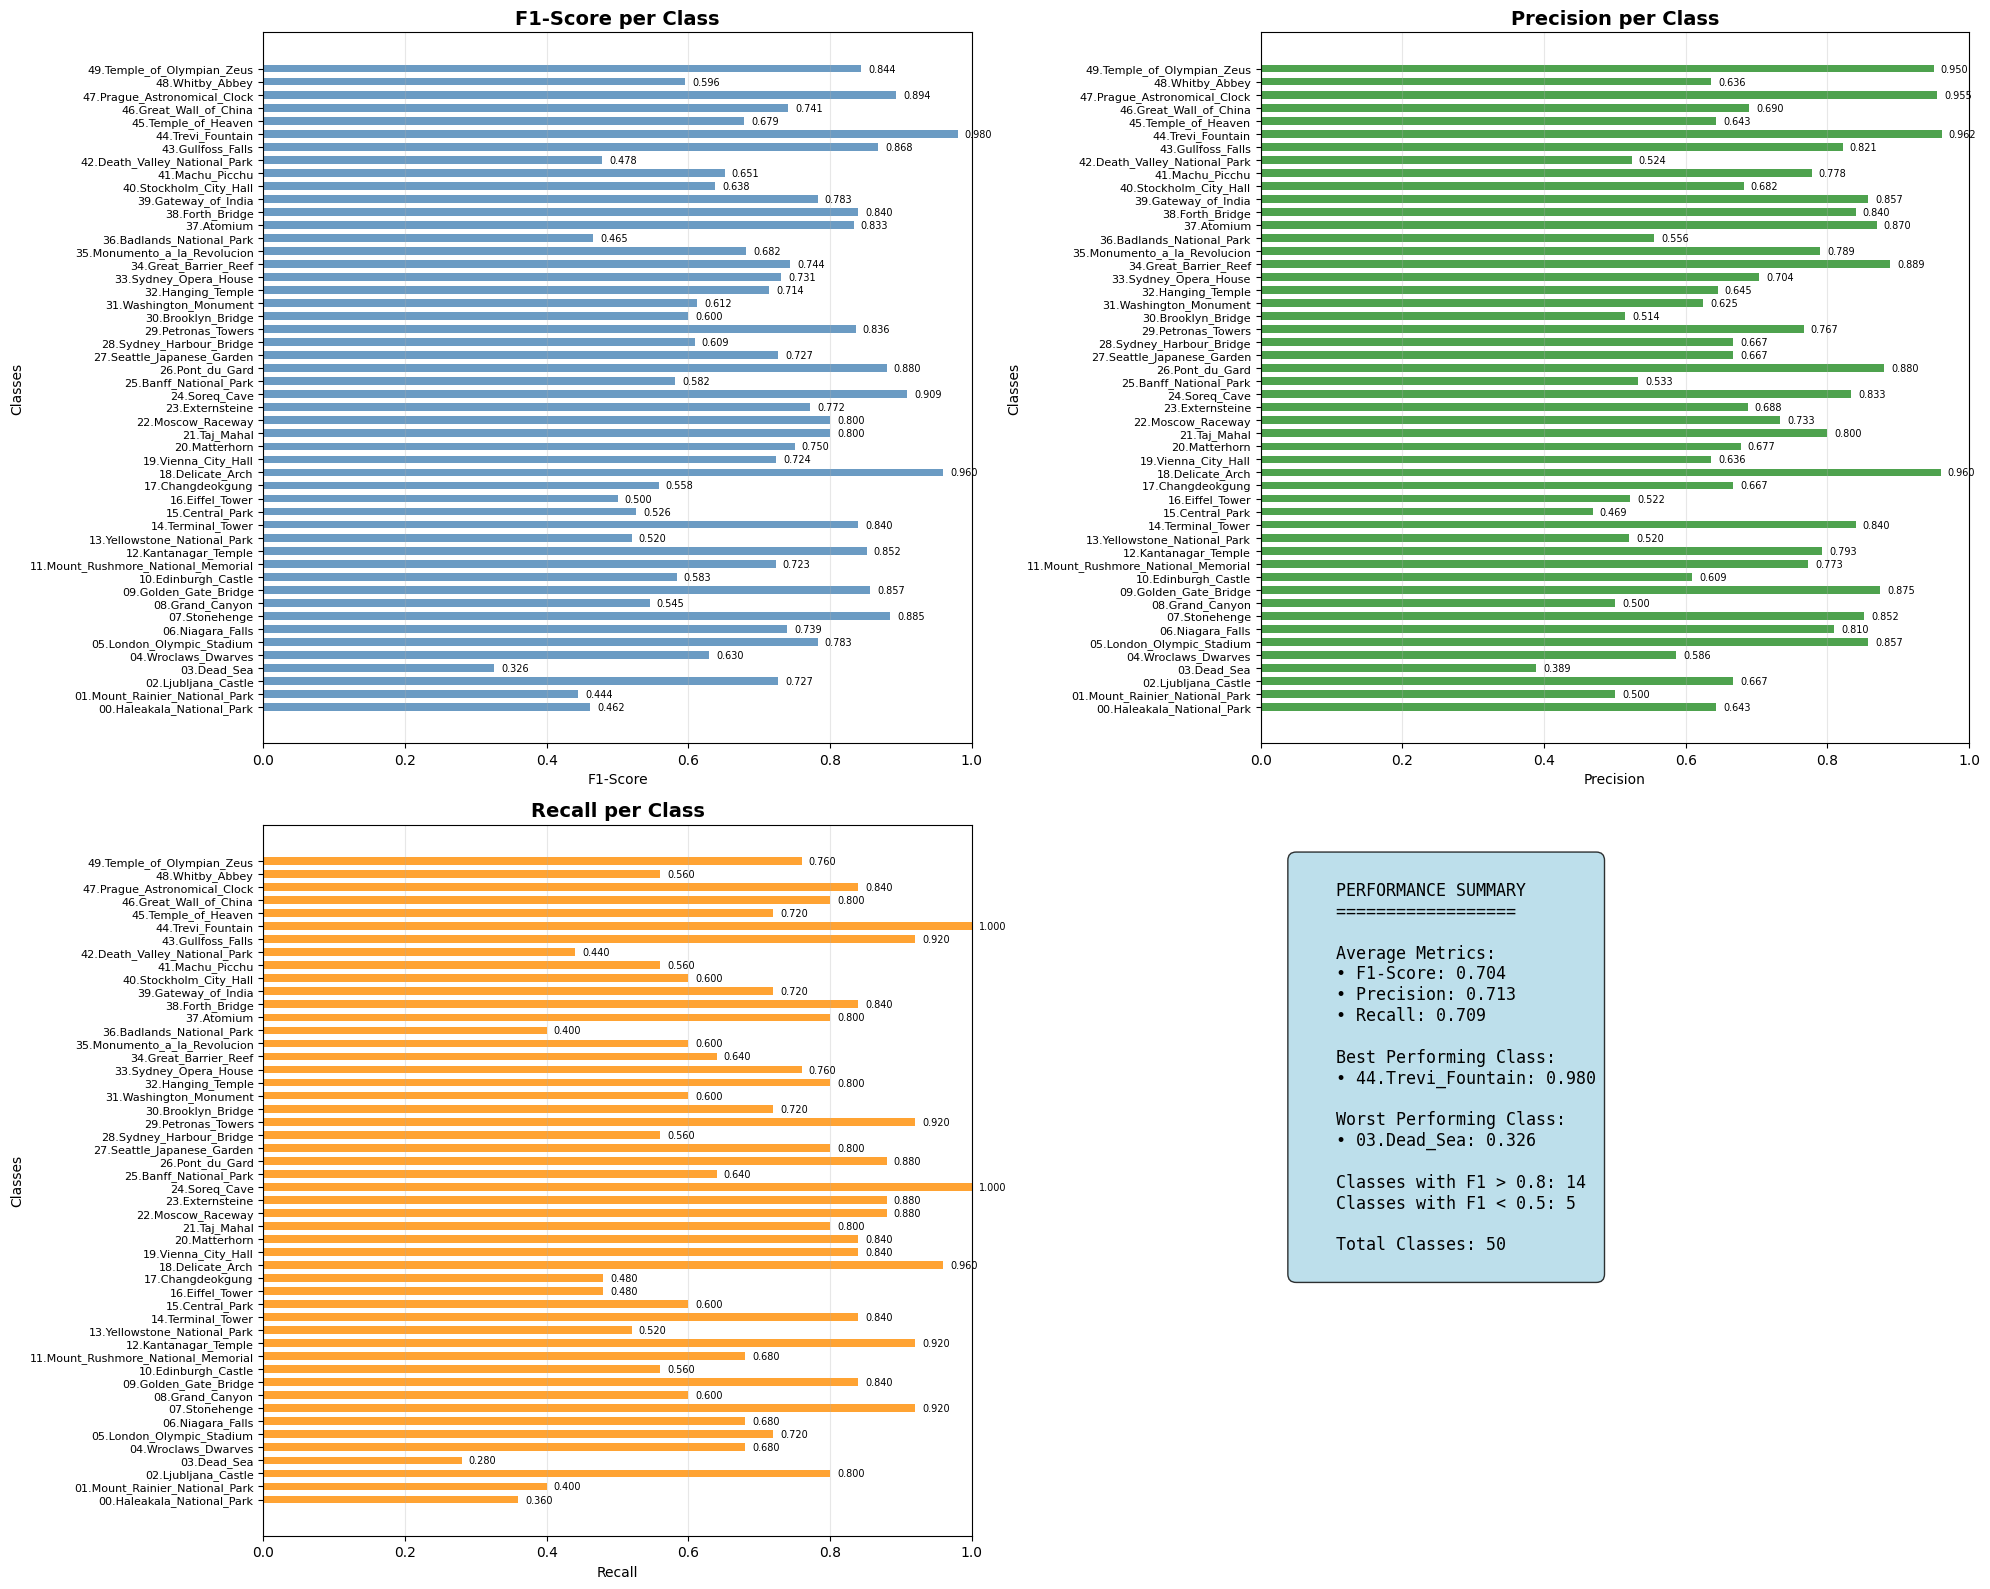

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
from src.helpers import visualize_comprehensive_metrics
visualize_comprehensive_metrics(truth, pred, class_names)

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._boots

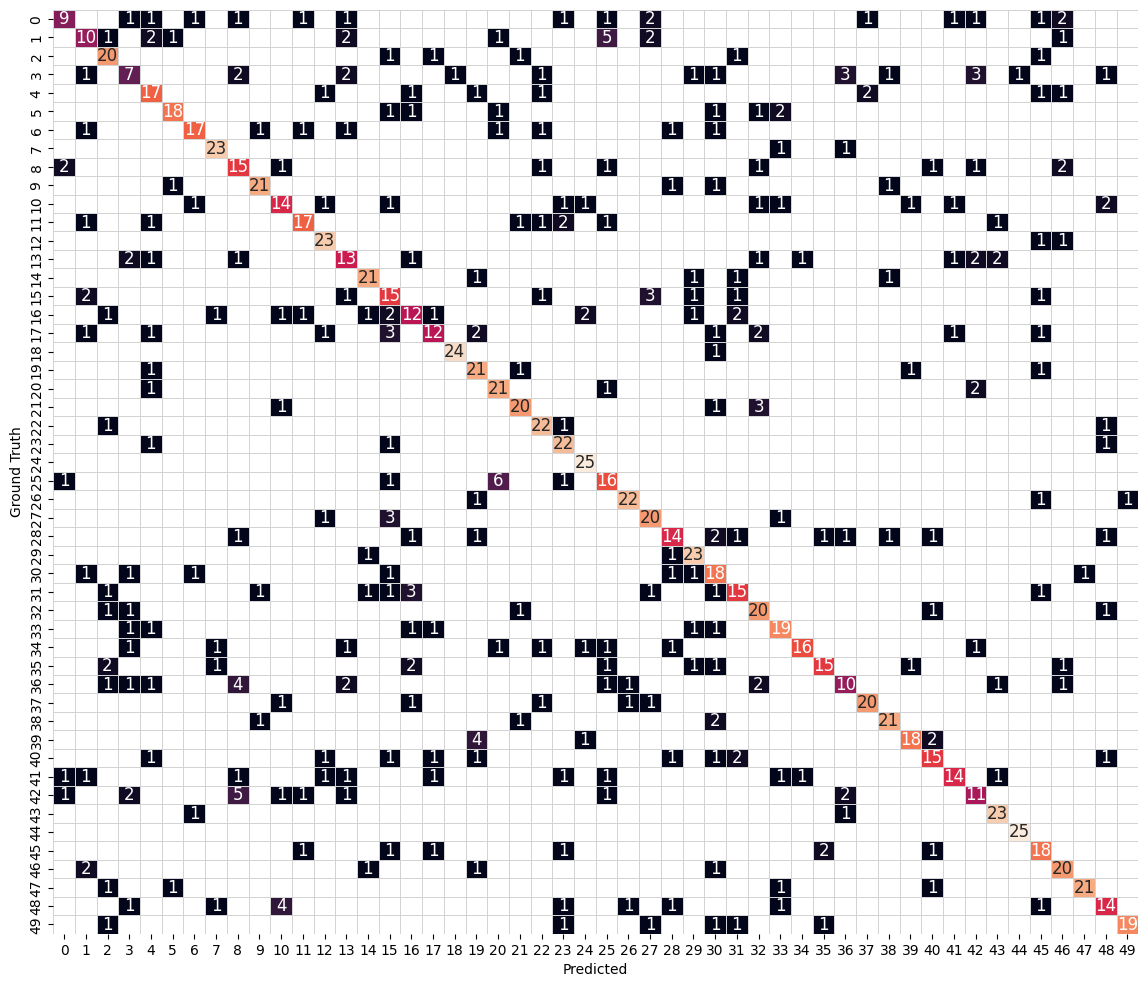

In [ ]:
from src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)

## Step 8: Try Grad-CAM

In [ ]:
from src.CNN_model import MyModel
import torch

model = MyModel(num_classes=50, dropout=0.5).cpu()


In [ ]:
model

MyModel(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(k

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


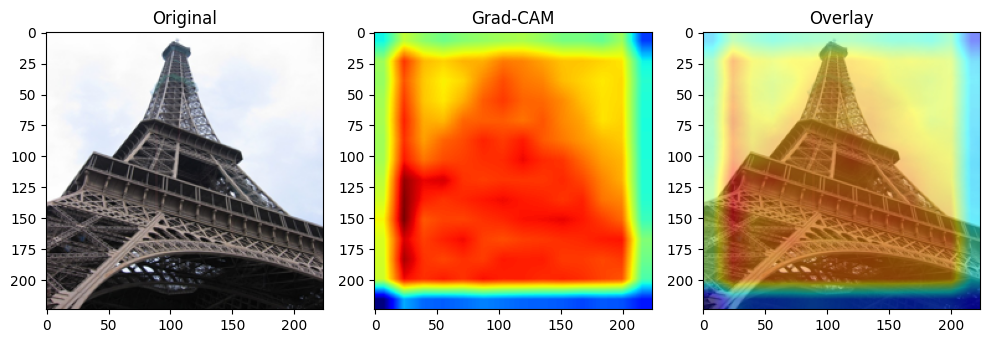

In [ ]:
from src.helpers import generate_grad_cam, plot_grad_cam

image_path = '/content/drive/MyDrive/Landmark_classification_tagging/landmark_images/train/16.Eiffel_Tower/08caf68108cf223d.jpg'
img, cam, pred_class = generate_grad_cam(image_path,model)
plot_grad_cam(img, cam)